In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp
import astropy.units as u
from astropy.coordinates import SkyCoord

import sys
sys.path.extend(['/Users/lynnej/other_repos/'])

In [55]:
from tvs_software_tools import generate_gp_maps

## Set up sky grid and information ##

In [396]:
from rubin_sim import data as rs_data
from rubin_sim.utils import _angularSeparation

class SurveyMap:
    def __init__(self, nside=64, default_filter_balance=None):
        self.nside = nside
        # healpix indexes
        self.hpid = np.arange(0, hp.nside2npix(nside))
        # Ra/dec in degrees and other coordinates
        self.ra, self.dec = hp.pix2ang(nside, self.hpid, lonlat=True)
        self.coord = SkyCoord(ra=self.ra * u.deg, dec=self.dec * u.deg, frame='icrs')
        self.eclip_lat = self.coord.barycentrictrueecliptic.lat.deg
        self.eclip_lon = self.coord.barycentrictrueecliptic.lon.deg
        self.gal_lon = self.coord.galactic.l.deg
        self.gal_lat = self.coord.galactic.b.deg
        # filterlist
        self.filterlist = ['u', 'g', 'r', 'i', 'z', 'y']
        # SRD values
        self.nvis_min_srd = 750
        self.nvis_goal_srd = 825
        self.area_min_srd = 15000
        self.area_goal_srd = 18000
        if default_filter_balance is None:
            self.default_filter_balance = {'u': 0.07, 'g': 0.09, 'r': 0.22, 
                                           'i': 0.22, 'z': 0.20, 'y': 0.20}
        else:
            self.default_filter_balance = self._normalize_filter_balance(default_filter_balance)
        self.maps = {}
        self.maps_perfilter = {}
        self.nvis = {}
    
    def read_dustmap(self, dustmapFile=None):
        # Dustmap from rubin_sim_data  - this is basically just a data directory
        # The dustmap data is downloadable from 
        # https://lsst.ncsa.illinois.edu/sim-data/rubin_sim_data/maps_may_2021.tgz
        # (then just set RUBIN_SIM_DATA_DIR to where you downloaded it, after untarring the file)
        if dustmapFile is None:
            datadir = rs_data.get_data_dir()
            if datadir is None:
                raise Exception('Cannot find datadir, please set "RUBIN_SIM_DATA_DIR"')
            datadir = os.path.join(datadir, 'maps', 'DustMaps')
            filename = os.path.join(datadir, 'dust_nside_%i.npz' % nside)
        self.dustmap = np.load(filename)['ebvMap']
        
    def _normalize_filter_balance(self, filter_balance):
        filtersum = np.array(list(filter_balance.values())).sum()
        tmp = {k: round(v/filtersum, 2) for k, v in filter_balance.items()}
        for f in self.filterlist:
            if f not in tmp:
                tmp[f] = 0
        return tmp
    
    # The various regions take the approach that they should be independent
    # And after setting all of the regions, we take the max value (per filter?) in each part of the sky
    # The individual components are updated, so that we can still calculate survey fraction per part of the sky
    
    def _set_exwfd(self, dust_limit=0.199, dec_min=-67, dec_max=12, 
                   smoothing_cutoff=0.57, smoothing_beam=10,
                   nvis_exwfd=825*1.08,
                   exgal_filter_balance=None):
        # Define extragalactic WFD between dec_min and dec_max with low dust extinction 
        # These dec and dust limits are used to define the other survey areas as well.
        # This means setting each part of the footprint depends on having already set some previous pieces..
        self.dust_limit = dust_limit
        self.dec_min = dec_min
        self.dec_max = dec_max
        if exgal_filter_balance is None:
            self.exgal_filter_balance = self.default_filter_balance
        else:
            self.exgal_filter_balance = self._normalize_filter_balance(exgal_filter_balance)
        
        # Set the detailed dust boundary 
        self.dust_exwfd = np.where((self.dec > self.dec_min) & (self.dec < self.dec_max) 
                                   & (self.dustmap < self.dust_limit), 1, 0)
        # Set the smoothed dust boundary using the original dustmap and smoothing it with gaussian PSF
        self.exwfd = np.where((self.dustmap < self.dust_limit), 1, 0)
        self.exwfd = hp.smoothing(self.exwfd, fwhm=np.radians(smoothing_beam))
        self.exwfd = np.where((self.dec > self.dec_min) & (self.dec < self.dec_max) 
                              & (self.exwfd>smoothing_cutoff), 1, 0)

        # Make per-filter maps for the footprint
        self.exwfd_maps = {}
        for f in self.filterlist:
            self.exwfd_maps[f] = self.exwfd * self.exgal_filter_balance[f]
        # Make these easy to access
        self.maps['exwfd'] = self.exwfd
        self.maps_perfilter['exwfd'] = self.exwfd_maps
        self.nvis['exwfd'] = nvis_exwfd

    def _set_magellanic_clouds(self, lmc_radius=10, smc_radius=5, 
                              nvis_mcs = 825,
                              mcs_filter_balance=None):
        # Define the magellanic clouds region
        if mcs_filter_balance is None:
            self.mcs_filter_balance = self.default_filter_balance
        else:
            self.mcs_filter_balance = self._normalize_filter_balance(mc_filter_balance)

        self.mcs = np.zeros(hp.nside2npix(nside))
        # Define the LMC center and size
        lmc_ra = np.radians(80.893860)
        lmc_dec = np.radians(-69.756126)
        self.lmc_radius = np.radians(lmc_radius)
        # Define the SMC center and size
        smc_ra = np.radians(13.186588)
        smc_dec = np.radians(-72.828599)
        self.smc_radius = np.radians(smc_radius)
        # Define the LMC pixels
        dist_to_lmc = _angularSeparation(lmc_ra, lmc_dec, np.radians(self.ra), np.radians(self.dec))
        lmc_pix = np.where(dist_to_lmc < self.lmc_radius)
        self.mcs[lmc_pix] = 1
        # Define the SMC pixels
        dist_to_smc = _angularSeparation(smc_ra, smc_dec, np.radians(self.ra), np.radians(self.dec))
        smc_pix = np.where(dist_to_smc < self.smc_radius)
        self.mcs[smc_pix] = 1
        
        # Make per-filter maps for the footprint
        self.mcs_maps = {}
        for f in self.filterlist:
            self.mcs_maps[f] = self.mcs * self.mcs_filter_balance[f]
        self.maps['mcs'] = self.mcs
        self.maps_perfilter['mcs'] = self.mcs_maps
        self.nvis['mcs'] = nvis_mcs
    
    def __set_bulge_diamond(self, center_width, end_width, gal_long1, gal_long2):
        """
        Define a Galactic Bulge diamond-ish region.

        Parameters
        ----------
        center_width : float
            Width at the center of the galactic plane region.
        end_width : float
            Width at the remainder of the galactic plane region.
        gal_long1 : float
            Longitude at which to start the GP region.
        gal_long2 : float
            Longitude at which to stop the GP region.
            Order matters for gal_long1 / gal_long2!
        Returns
        -------
        np.ndarray
        """
        # Reject anything beyond the central width.
        bulge = np.where(np.abs(self.gal_lat) < center_width, 1, 0)
        # Apply the galactic longitude cuts, so that plane goes between gal_long1 to gal_long2.
        # This is NOT the shortest distance between the angles.
        gp_length = (gal_long2 - gal_long1) % 360
        # If the length is greater than 0 then we can add additional cuts.
        if gp_length > 0:
            # First, remove anything outside the gal_long1/gal_long2 region.
            bulge = np.where(((self.gal_lon - gal_long1) % 360) < gp_length, bulge, 0)
            # Add the tapers.
            # These slope from the center (gp_center @ center_width)
            # to the edges (gp_center + gp_length/2 @ end_width).
            half_width = gp_length / 2.
            slope = (center_width - end_width) / half_width
            # The 'center' can have a wrap-around 0 problem
            gp_center = (gal_long1 + half_width) % 360
            # Calculate the longitude-distance between any point and the 'center'
            gp_dist = (self.gal_lon - gp_center) % 360
            gp_dist = np.abs(np.where((gp_dist > 180), (180 - gp_dist) % 180, gp_dist))
            lat_limit = np.abs(center_width - slope * gp_dist)
            bulge = np.where((np.abs(self.gal_lat)) < lat_limit, bulge, 0)
        return bulge
    
    def _set_galactic_plane(self, dec_max=12,
                            center_width_A=11, end_width_A=4, gal_long1_A=330, gal_long2_A=30, 
                           center_width_B=15, end_width_B=5, gal_long1_B=250, gal_long2_B=100,
                           gal_lat_width_max=23,
                           nvis_gal_A=825, nvis_gal_B=300, nvis_gal_min=250, gal_filter_balance=None):
        if gal_filter_balance is None:
            self.gal_filter_balance = {'u': 0.04, 'g': 0.22, 'r': 0.24,
                                      'i': 0.24, 'z': 0.22, 'y': 0.05}
        else:
            self.gal_filter_balance = self._normalize_filter_balance(gal_filter_balance)
        self.gal_dec_max = dec_max

        # Set up central bulge
        self.bulge_A = self.__set_bulge_diamond(center_width=center_width_A, end_width=end_width_A,
                                               gal_long1=gal_long1_A, gal_long2=gal_long2_A)
        self.bulge_A = np.where(self.dec > self.gal_dec_max, 0, self.bulge_A)
        # And a secondary bulge-ish region to follow further stars
        self.bulge_B = self.__set_bulge_diamond(center_width=center_width_B, end_width=end_width_B,
                                               gal_long1=gal_long1_B, gal_long2=gal_long2_B)
        self.bulge_B = np.where(self.dec > self.gal_dec_max, 0, self.bulge_B)
        # Remove regions of these bulges which go further north than dec_max
        # Set up 'background' galactic plane visits 
        self.gp_bkgnd = np.where((np.abs(self.gal_lat) < gal_lat_width_max) & (self.dec < self.dec_max), 1, 0)
        # Remove the areas that overlap
        self.bulge_B = self.bulge_B - self.bulge_A
        self.gp_bkgnd = self.gp_bkgnd - self.bulge_A - self.bulge_B
        
        # Add them together
        self.gal = (self.gp_bkgnd * nvis_gal_min / nvis_gal_A 
                   + self.bulge_B * nvis_gal_B / nvis_gal_A
                   + self.bulge_A)
        
        # Make per-filter maps for the footprint
        self.gal_maps = {}
        for f in self.filterlist:
            self.gal_maps[f] = self.gal * self.gal_filter_balance[f]
        self.maps['gal'] = self.gal
        self.maps_perfilter['gal'] = self.gal_maps
        self.nvis['gal'] = nvis_gal_A
            
    def _set_nes(self, eclat_min=-15, eclat_max=10, eclip_dec_min=-10, eclip_ra_max=180, 
                 nvis_nes=400, nes_filter_balance=None):
        if nes_filter_balance is None:
            self.nes_filter_balance =  {'u': 0.0, 'g': 0.2, 'r': 0.3, 'i': 0.3, 'z': 0.2, 'y': 0.0}
        else:
            self.nes_filter_balance = self._normalize_filter_balance(nes_filter_balance)
        # NES ecliptic latitude values tend to be assymetric because NES goes so far north
        self.eclat_min = eclat_min
        self.eclat_max = eclat_max
        self.eclip_dec_min = eclip_dec_min
        self.eclip_ra_max = eclip_ra_max

        self.nes = np.where(((self.eclip_lat > self.eclat_min) | 
                             ((self.dec > self.eclip_dec_min) & (self.ra < self.eclip_ra_max)))
                             & (self.eclip_lat < self.eclat_max), 1, 0)
        self.nes_maps = {}
        for f in self.filterlist:
            self.nes_maps[f] = self.nes * self.nes_filter_balance[f]
        self.maps['nes'] = self.nes
        self.maps_perfilter['nes'] = self.nes_maps
        self.nvis['nes'] = nvis_nes
            
    def _set_scp(self, nvis_scp=120, dec_max=12, scp_filter_balance=None):
        if scp_filter_balance is None:
            self.scp_filter_balance = {'u': 0.17, 'g': 0.17, 'r': 0.17, 'i': 0.17, 'z': 0.17, 'y': 0.17}
        else:
            self.scp_filter_balance = self._normalize_filter_balance(scp_filter_balance)
        # Basically this is a fill-in so that we don't have any gaps below the max dec limit for the survey
        # I would expect most of this to be ignored
        self.scp = np.where(self.dec < dec_max, 1, 0)
        self.scp_maps = {}
        for f in self.filterlist:
            self.scp_maps[f] = self.scp * self.scp_filter_balance[f]
        self.maps['scp'] = self.scp
        self.maps_perfilter['scp'] = self.scp_maps
        self.nvis['scp'] = nvis_scp
    
    def set_maps(self):
        self.read_dustmap()
        self._set_exwfd()
        self._set_magellanic_clouds()
        self._set_galactic_plane()
        self._set_nes()
        self._set_scp()
    
    def combine_maps(self):
        map_order = ['exwfd', 'gal', 'mcs', 'nes', 'scp']

        total_perfilter = {}
        for f in self.filterlist:
            total_perfilter[f] = np.zeros(len(self.hpid), float)
        for m in map_order:
            if m in self.maps:
                for f in self.filterlist:
                    total_perfilter[f] = np.maximum(total_perfilter[f], 
                                                    self.maps_perfilter[m][f] * self.nvis[m])
        total = np.zeros(len(self.hpid), float)
        for f in self.filterlist:
            total += total_perfilter[f]
        return total, total_perfilter
        

dict_keys(['exwfd', 'mcs', 'gal', 'nes', 'scp'])


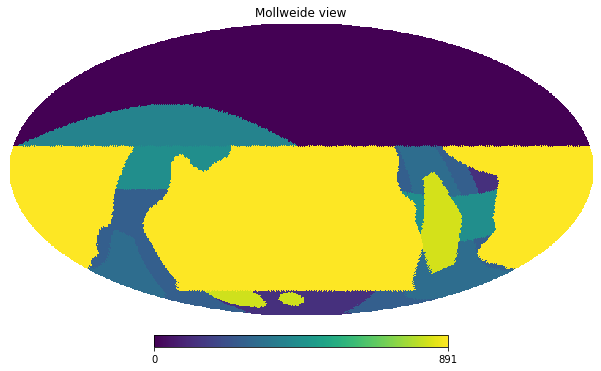

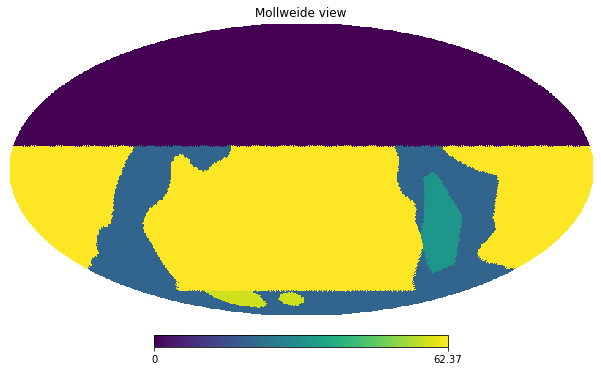

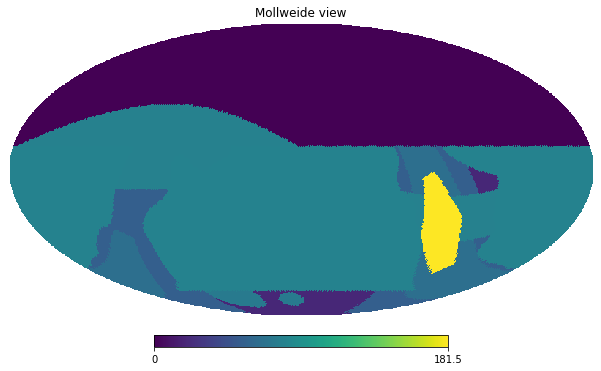

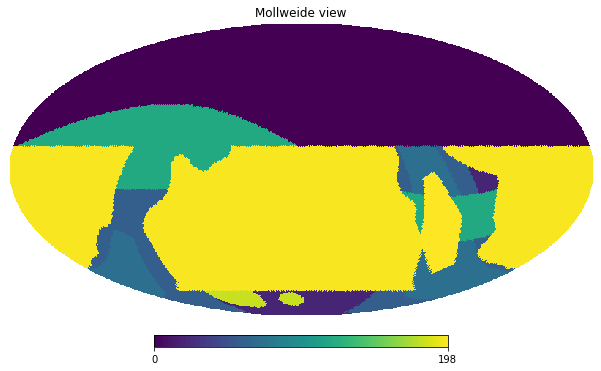

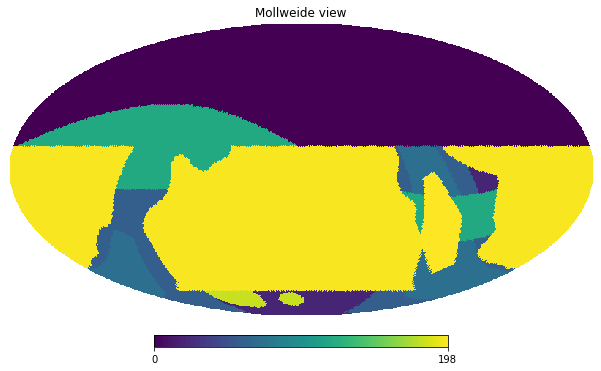

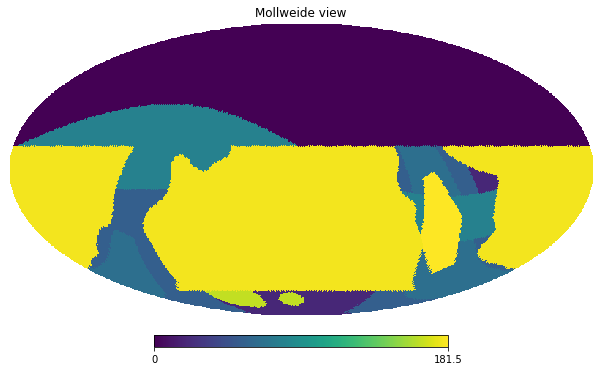

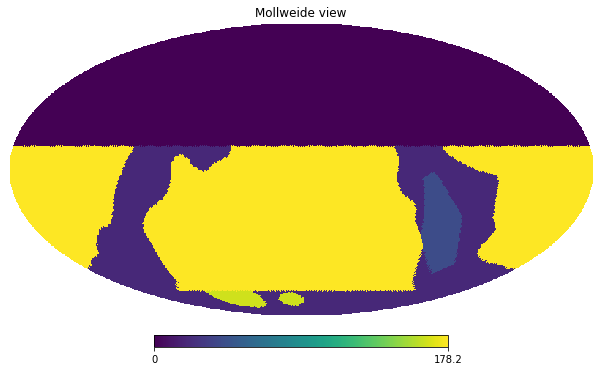

In [398]:
sky = SurveyMap()
sky.set_maps()
print(sky.maps.keys())
total, total_pf = sky.combine_maps()
hp.mollview(total)
for f in sky.filterlist:
    hp.mollview(total_pf[f])

In [202]:
def scalingfunc(survey_frac=None, nvisits_per_pointing=None, area=None):
    # How much survey time .. approximately .. is it likely to take to cover a given area? 
    # We can use a rough scaling derived from 
    # https://github.com/lsst-pst/survey_strategy/blob/master/fbs_1.7/SurveyFootprints-NvisitsVsArea.ipynb
    # x = (scale['NvisitPerPoint*']/825) * (scale['Area']/18000) / (scale['t']/0.77)  == constant (~1)
    defaults = {'survey_frac': 0.77, 'area': 18000, 'nvisits_per_pointing': 825}
    if area is None:
        area = (survey_frac / defaults['survey_frac']) / \
                (nvisits_per_pointing / defaults['nvisits_per_pointing'])
        return area * defaults['area']
    elif nvisits_per_pointing is None:
        nvisits_per_pointing = (survey_frac / defaults['survey_frac']) / (area / defaults['area'])
        return nvisits_per_pointing * defaults['nvisits_per_pointing']
    elif survey_frac is None:
        survey_frac = nvisits_per_pointing / defaults['nvisits_per_pointing'] * area / defaults['area']
        return survey_frac * defaults['survey_frac']
        
def calc_area_time(footprint, nvis_peak=825, verbose=False):
    # Given a survey footprint, returns (effective) area in footprint and fraction of survey time required
    eff_area = footprint.sum() * hp.nside2pixarea(nside, degrees=True)
    nvis_srd_min = 750 * 1.08
    srd_area = (footprint[np.where(footprint * nvis_peak > nvis_srd_min)].sum() 
                * hp.nside2pixarea(nside, degrees=True))
    # survey time required? 
    time = scalingfunc(nvisits_per_pointing=nvis_peak, area=eff_area)
    if (verbose):
        print(f'Effective area in footprint {eff_area}')
        print(f'Area in footprint which can contribute to SRD {srd_area}')
        print(f'Approximate fraction of survey time required for footprint {time}')
    return eff_area, srd_area, time

In [203]:
nside = 64
sky = SurveyMap(nside=nside)
sky.read_dustmap()

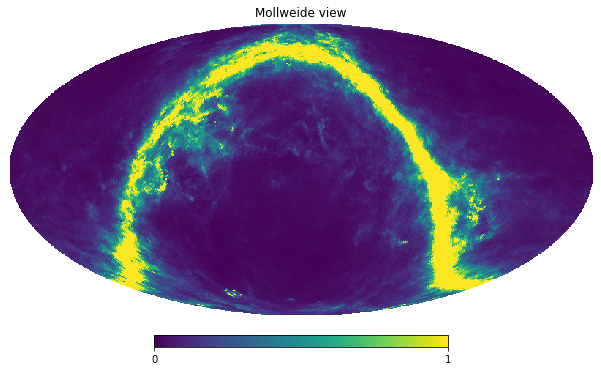

In [145]:
hp.mollview(sky.dustmap, min=0, max=1, norm=None)

## Estimate of survey time requirements ##

Text(0, 0.5, 'Survey fraction')

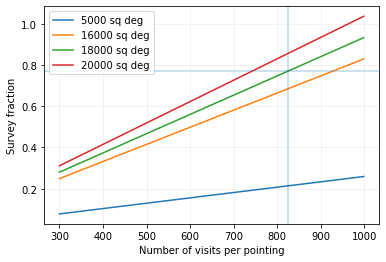

In [124]:
# which leads us to the fraction of a 2x15s 10year survey required 
# from the simulations in the notebook referenced above, I think this is accurate to an order of a % or a few,
# although smaller areas may have more 'edge effects' which would increase their required time 

nvis = np.arange(300, 1000)
for area in (5000, 16000, 18000, 20000):
    plt.plot(nvis, scalingfunc(nvisits_per_pointing=nvis, area=area), label=f'{area} sq deg')
plt.axhline(0.77, alpha=0.3)
plt.axvline(825, alpha=0.3)
plt.grid(alpha=0.2)
plt.legend(loc='upper left')
plt.xlabel('Number of visits per pointing')
plt.ylabel('Survey fraction')

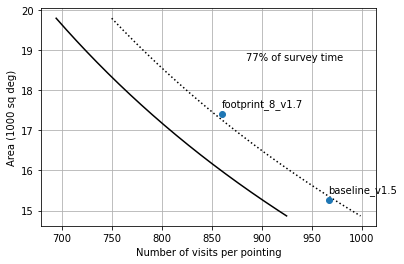

In [125]:
nvis=np.arange(750, 1000)
plt.plot(nvis, scalingfunc(nvisits_per_pointing=nvis, survey_frac=0.77)/1000, 'k:')
plt.plot(nvis/1.08, scalingfunc(nvisits_per_pointing=nvis, survey_frac=0.77)/1000, 'k-')
plt.plot([860, 967], [17413/1000, 15260/1000], linestyle='', marker='o')
plt.annotate('footprint_8_v1.7', xy=[860, 17413/1000+.2])
plt.annotate('baseline_v1.5', xy=[967, 15260/1000+0.2])
plt.figtext(s='77% of survey time', x=0.6, y=0.7)
plt.xlabel('Number of visits per pointing')
plt.ylabel('Area (1000 sq deg)')
plt.grid()
# The solid line = the scaling function / 1.08 .. which both is about the level of variation between 'Minimum'
# number of visits per pointing and "Median" nvisits/pointing (in most simulations) AND a not-unreasonable amount
# of number of visits per pointing to hold as 'contingency'
# .. in other words, plan for the solid line, hope for the dashed line (?)

## Footprint per filter ## 
Due to (potentially) different filter balance being requested by GP science, and overlap between GP priority map footprint and the extragalactic WFD, we need to account for footprint requests per filter. 

Additionally, the GP priority regions contributes only small amount of area toward the SRD requirements (minimum 17500 sq deg covered to min 750 visits per pointing): the bulk of this area must generally be brought in through extragalactic coverage. 

## Low-dust extinction extragalactic

This area is the primary contributor to the SRD requirements (absolute minimum in both nvisits and area: 15000 sq deg to 750 visits). Design goals are 18,000 sq deg to 825 visits per pointing. This pushes the extragalactic footprint toward bigger area; note that this may require rolling cadence implementation over this area, in order to recover SN performance (SN performance prefers more visits, preferably closer to 1000, which is the stretch goal).

There is some overlap between this area and the GP priority map footprint above, which may require visits in different filters (and those visits may even need to be at different cadences). 
Start out considering them separately and see what we can combine later.

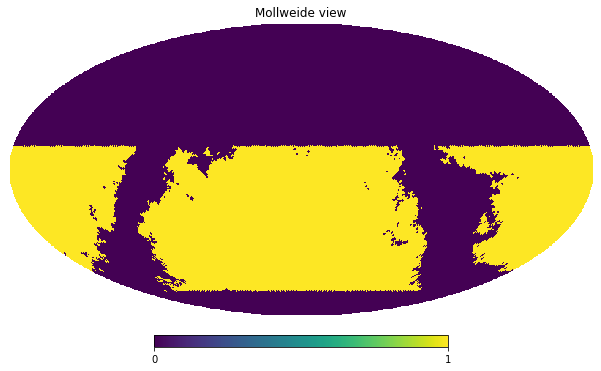

In [204]:
# Define extragalactic WFD between -72 and +12.5 with low dust extinction (dust extinction limit = 0.2)
# These dec and dust limits are used to define the other survey areas as well. 
dust_limit = 0.2
dec_max = 12.0
dec_min = -67.0

exgal_filter_balance = {'u': 0.07, 'g': 0.09, 'r': 0.22, 'i': 0.22, 'z': 0.20, 'y': 0.20}

nvis_exgal = int(825*1.08)

sky._set_exwfd(dust_limit=dust_limit, dec_min=dec_min, dec_max=dec_max, nvis_exgal=nvis_exgal,
              smoothing_cutoff=0.57, smoothing_beam=10,
              exgal_filter_balance=exgal_filter_balance)

# Where is this (detailed dust footprint) on the sky?
hp.mollview(sky.dust_exwfd, max=1, norm=None)

Now - we don't want to leave 'islands' unobserved within this WFD area and we want a smoother boundary at the dust extinction edges. So we've also smoothed the dust-extinction edges. 

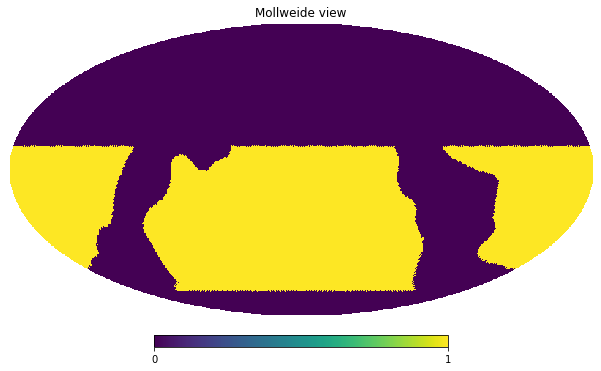

In [147]:
hp.mollview(sky.exwfd)

area within dust_boundary wfd 17240.77005992779
dust-free area within dust-boundary wfd 16974.713974395847

area = 2 is added into smoothed dust boundary (too much dust, but now included),
 area = 1 is overlap (good dust and in smoothed boundary),
 and area = -1 would pass dust limit but is not included


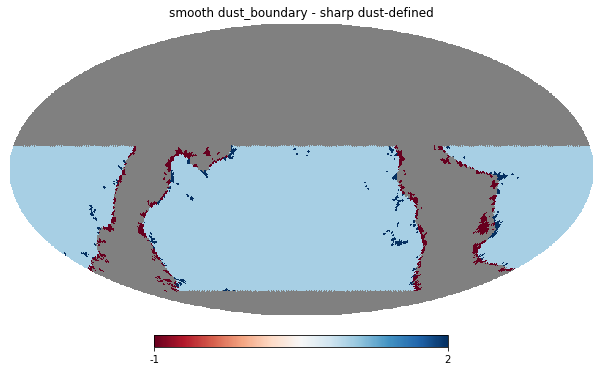

In [317]:
exgal_area, srd_area, t_exgal = calc_area_time(sky.exwfd, nvis_exgal)
dust_free_area, j, j = calc_area_time(sky.exwfd[np.where(sky.dustmap < sky.dust_limit)], nvis_exgal)

print('area within dust_boundary wfd', exgal_area)
print('dust-free area within dust-boundary wfd', dust_free_area)

tmp = sky.exwfd * 2 - sky.dust_exwfd
tmp = np.where(tmp == 0, hp.UNSEEN, tmp)
hp.mollview(tmp, title='smooth dust_boundary - sharp dust-defined', cmap='RdBu')
print('')
print('area = 2 is added into smoothed dust boundary (too much dust, but now included),\n '\
      'area = 1 is overlap (good dust and in smoothed boundary),\n '\
      'and area = -1 would pass dust limit but is not included')

In [318]:
# Summary of area/time.

print(f'Area in extragalactic wfd {exgal_area}')
print(f'Area in extragalactic wfd which is below dust-limit {dust_free_area}')

# survey time required? 
print(f"Survey fraction required for extragalactic WFD area {exgal_area: .2f}, at {nvis_exgal} "\
      f"visits per pointing is {t_exgal: .3f}")

Area in extragalactic wfd 17240.77005992779
Area in extragalactic wfd which is below dust-limit 16974.713974395847
Survey fraction required for extragalactic WFD area  17240.77, at 891 visits per pointing is  0.797


## Galactic Plane ##

Using the "galactic plane priority map" defined by the TVS/SMWLV groups to set some information about 'ideal' coverage. However, this is also a complicated mapping so we will again use a simpler definition of area around bulge and use galactic plane priority map as weighting to evaluate priority.

In [130]:
# Note something in the TVS code doesn't seem to work appropriately at nside 128 .. use nside=64. 
gp_maps = generate_gp_maps(nside)

/Users/lynnej/other_repos/tvs_software_tools/generate_galplane_priority_maps.py:50: RuntimeWarning: divide by zero encountered in log10
  hp_log_star_density = np.log10(hp_star_density)


filter gal-balance exga-balance
u 0.04 0.07
g 0.22 0.09
r 0.24 0.22
i 0.24 0.22
z 0.22 0.2
y 0.05 0.2


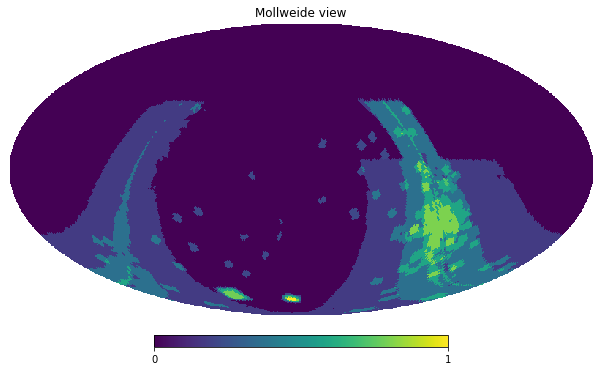

In [150]:
# gal plane priority maps are per filter - use this to get desired filter balance and to gather all-band priority map
gal_total = np.zeros(len(gp_maps['r']), float)
for f in gp_maps:
    gal_total += gp_maps[f]
    #print(f, gp_maps[f].max(), gp_maps[f].min())
# Scale so the peak is 1 (to assign total number of visits across all filters later)
norm = gal_total.max()
gal_total = gal_total / norm

gal_filter_balance = {}
print('filter gal-balance exga-balance')
for f in sky.filterlist:
    gal_filter_balance[f] = round(gp_maps[f].max() / norm, 2)
    print(f, gal_filter_balance[f], exgal_filter_balance[f])

hp.mollview(gal_total, max=1)

There is not enough time available to observe the entire map to 825 visits per pointing, but we can do a hybrid -- take some fraction of the map and observe that to 825 visits per pointing and then observe the rest at the fraction given in the map. Use this to evaluate generally how much area we might be able to cover, for later reference. 

(I'm also going to use the fact that I already checked about number of visits per pointing in each filter and the overlap with the extragalactic area means that (assuming the cadence is ok) the visits per filter are satisfied by the extragalactic coverage - so I'll exclude that for this area calculation - see the check below. There's a similar issue with NES coverage away from the bulge, although there it's also filter-dependent).

In [319]:
nvis_gal_peak = 825
for X in np.arange(0, 1.05, 0.1):
    gal_total = np.zeros(len(gp_maps['r']), float)
    for f in gp_maps:
        gal_total += gp_maps[f]
    norm = gal_total.max()
    gal_total = gal_total / norm
    gal_total = np.where(sky.exwfd == 1, 0, gal_total)
    # 'flatten' the map at 'X' - and set this to 825 visits per pointing. 
    # Remainder of plane will be at specified level relative to 825 (i.e. parts get 80 visits pp)
    gal_total = np.where(gal_total > X, 1, gal_total)
    eff_area, gp_srd_area, frac = calc_area_time(gal_total, nvis_gal_peak)
    print(f'{X:.2f} Effective area {eff_area:.2f} (SRD area {gp_srd_area:.2f}) Survey fraction {frac :.3f}')

0.00 Effective area 7919.57 (SRD area 7919.57) Survey fraction 0.339
0.10 Effective area 7919.57 (SRD area 7919.57) Survey fraction 0.339
0.20 Effective area 4921.62 (SRD area 4290.47) Survey fraction 0.211
0.30 Effective area 4874.33 (SRD area 4230.04) Survey fraction 0.209
0.40 Effective area 3088.22 (SRD area 1389.87) Survey fraction 0.132
0.50 Effective area 3074.37 (SRD area 1362.17) Survey fraction 0.132
0.60 Effective area 2707.89 (SRD area 475.04) Survey fraction 0.116
0.70 Effective area 2707.89 (SRD area 475.04) Survey fraction 0.116
0.80 Effective area 2698.82 (SRD area 435.59) Survey fraction 0.115
0.90 Effective area 2615.07 (SRD area 7.55) Survey fraction 0.112
1.00 Effective area 2615.07 (SRD area 7.55) Survey fraction 0.112


So we could try to use X=0.7 and see what that looks like. (we know we have an oversubscription problem, but this gives us a bit more SRD area for not a lot of time). 
BUT, this does give a pretty complicated looking footprint - which we're trying to avoid. And it also leaves parts of the plane with very little coverage. 

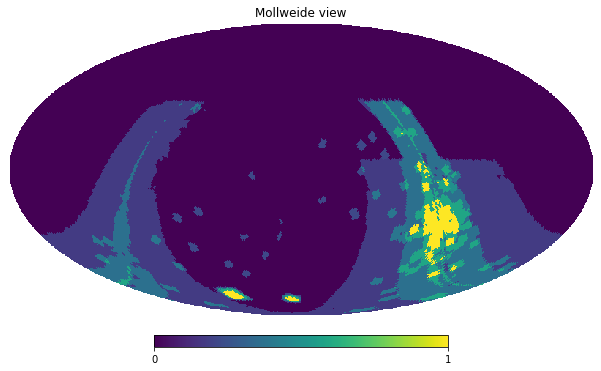

In [321]:
X = 0.7

gal_total = np.zeros(len(gp_maps['r']), float)
for f in gp_maps:
    gal_total += gp_maps[f]
gal_total = gal_total / gal_total.max()
gal_total = np.where(gal_total > X, 1, gal_total)
hp.mollview(gal_total)

So now let's set up the simpler coverage map and look at the comparison.

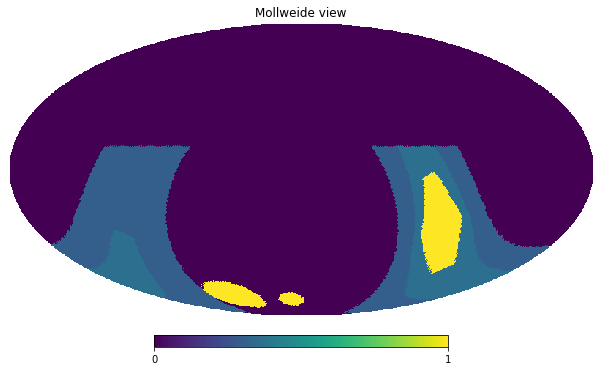

In [323]:
sky._set_galactic_plane(gal_filter_balance=gal_filter_balance)
tmp = sky.gal + sky.mcs
hp.mollview(tmp)


area = 0 matches coverage in priority map, area = 1 is more coverage, area = -1 is missed area


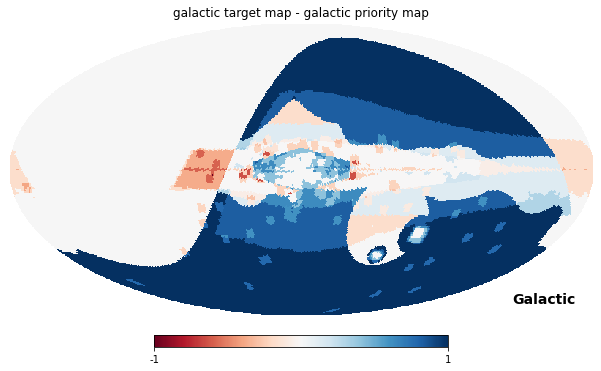

In [332]:
# Compare to priority map
t = (tmp + sky.maps['exwfd']) - gal_total
hp.mollview(t, cmap='RdBu', coord=['C', 'G'], 
            title='galactic target map - galactic priority map')
print('')
print('area = 0 matches coverage in priority map, area = 1 is more coverage, area = -1 is missed area')

In [333]:
tmp = np.where(sky.maps['exwfd']==0, tmp, 0)
gal_eff_area, gal_srd_area, t_gal = calc_area_time(tmp, sky.nvis['gal'])
print(f"effective area in galactic plane {gal_eff_area}, srd contributed area {gal_srd_area}")
print(f"fraction of survey time required {t_gal}")

effective area in galactic plane 2894.087953814215, srd contributed area 1175.0111032956336
fraction of survey time required 0.12380265135760807


## Ecliptic coverage ##

The ecliptic plane has significant overlap with over survey coverage as well. The extragalactic WFD is compatible, so will use that wherever it overlaps. The GP coverage may have different filter / time requirements, but needs more details to check. The ecliptic coverage needs to pick up some pointings around the outside edges of the plane which were not included in the galactic plane priority map -- this is worth checking with the solar system collaboration, as these visits may not be the most useful due to stellar confusion (but are in very interesting areas of the sky for exploration, as these have not generally been covered yet).

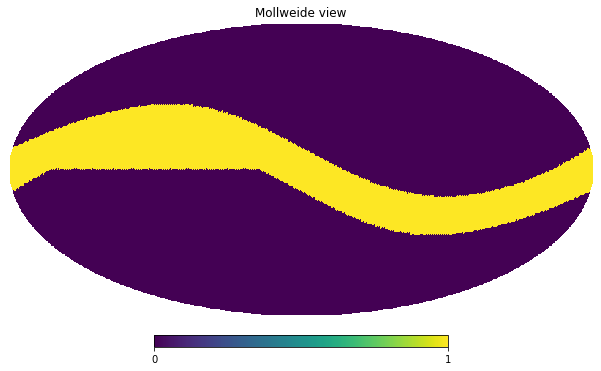

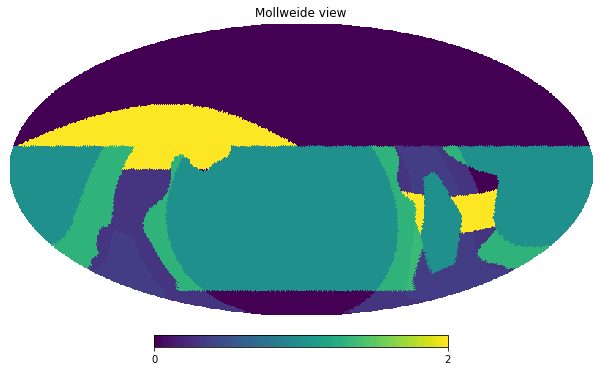

In [407]:
# Ecliptic latitude limits are not symmetric because the northern most point of the ecliptic is +23
eclat_min = -10
eclat_max = 10. 
eclip_dec_min = 0
nvis_nes = 400

sky._set_nes(nvis_nes=nvis_nes, eclat_min=eclat_min, eclat_max=eclat_max, eclip_dec_min=eclip_dec_min)

hp.mollview(sky.nes, norm=None)

tmp = np.where((sky.maps['exwfd'] == 1) | (sky.maps['gal'] > .4), 0, sky.nes)
hp.mollview(tmp*2 + sky.maps['exwfd'] + sky.maps['gal'], max=2)

In [408]:
# how much area is covered? 
nes_area, j, t_nes = calc_area_time(tmp, sky.nvis['nes'])

print(f'Area in ecliptic plane total {nes_area}')
print(f"Survey fraction required for north ecliptic spur {nes_area: .2f}, at {sky.nvis['nes']} visits per pointing {t_nes:.3f}")

Area in ecliptic plane total 3449.4968818178954
Survey fraction required for north ecliptic spur  3449.50, at 400 visits per pointing 0.072


## Southern Celestial Pole ##

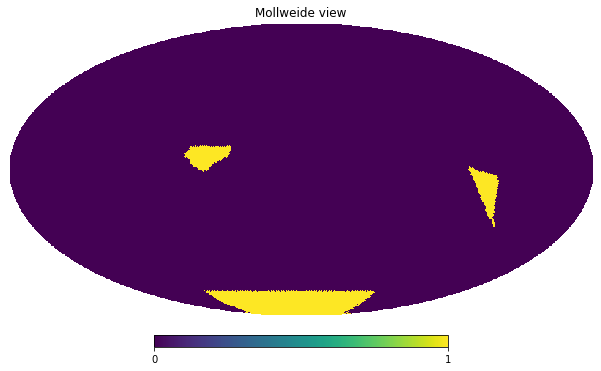

In [409]:
# Add light coverage to the southern celestial pole - the southern part of the sky that is not already covered.
sky._set_scp(dec_max=12)
tmp = np.where((sky.maps['exwfd'] == 1) | (sky.maps['gal'] > 0.2), 0, sky.maps['scp'])
hp.mollview(tmp)

In [410]:
scp_area, j, t_scp  = calc_area_time(tmp, sky.nvis['scp'])
print(f'Area in southern celestial pole {scp_area}')

print(f"Survey fraction required for south celestial pole {scp_area: .2f}, at {sky.nvis['scp']} visits per pointing {t_scp: .3f}")

Area in southern celestial pole 1467.0852918291196
Survey fraction required for south celestial pole  1467.09, at 120 visits per pointing  0.009


## Total ##

In [411]:
# We need at least 5% of the time for DDFs - 1% per pointing
t_ddf = 0.05
ddf_area = t_ddf / .01 * 9.6
# We need a few percent for mini-minisurveys (ToO, twilight NEO? DCR?)
t_mini = 0.03

There is very little survey overlap at this point (some in the NES though)

In [417]:
# Start with a basic survey footprint, just adding all of the above together.
surveyfootprint, survey_maps = sky.combine_maps()

In [413]:
# We do need to check that we're planning for about 18k sq deg to be visited to at least 825 per SRD
nvis_min_srd = 750
goal_srd = len(np.where(surveyfootprint >= nvis_min_srd)[0]) * hp.nside2pixarea(nside, degrees=True)
res_srd = len(np.where(surveyfootprint >= 825)[0]) * hp.nside2pixarea(nside, degrees=True)
print(f"Area covered to at least {nvis_min_srd} visits per pointing {goal_srd}")
print(f"Area covered to at least {825} visits per pointing {res_srd}")

Area covered to at least 750 visits per pointing 18415.781163223422
Area covered to at least 825 visits per pointing 18415.781163223422


In [415]:
t_total = t_exgal + t_gal + t_nes + t_scp
t_total += t_ddf + t_mini
# effective total area (because we're discounting parts of the GP which are not covered at full depth ..)
area_total = exgal_area + gal_eff_area + nes_area  + scp_area + ddf_area

pd.DataFrame([[exgal_area, t_exgal, sky.nvis['exwfd']], 
              [gal_eff_area, t_gal, sky.nvis['gal']],
              [nes_area, t_nes, sky.nvis['nes']], 
              [scp_area, t_scp, sky.nvis['scp']], 
              [ddf_area, t_ddf, np.nan], 
              [np.nan, t_mini, np.nan],
              [area_total, t_total, np.nan]], 
             columns=["Area (sq deg)", "Survey Fraction", "Nvis/pointing"], 
             index=["Extragalactic", "GP map", "NES",  "SCP", "DDF", "Mini", "Total"])

,Area (sq deg),Survey Fraction,Nvis/pointing
Extragalactic,17240.770060,0.796524,891.0
GP map,2894.087954,0.123803,825.0
NES,3449.496882,0.071545,400.0
SCP,1467.085292,0.009129,120.0
DDF,48.000000,0.050000,NaN
Mini,NaN,0.030000,NaN
Total,25099.440187,1.081000,NaN


/Users/lynnej/anaconda3/envs/rubin/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_over(newcm(1.0))
/Users/lynnej/anaconda3/envs/rubin/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_under(bgcolor)
/Users/lynnej/anaconda3/envs/rubin/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of 

Text(0.5, 1.0, 'Survey footprint (108.1%)')

<Figure size 720x576 with 0 Axes>

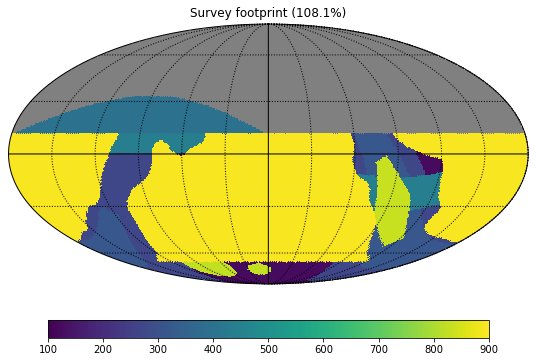

In [416]:
fig = plt.figure(figsize=(10, 8))
f = np.where(surveyfootprint == 0, hp.UNSEEN, surveyfootprint)
#hp.mollview(surveyfootprint, min=0, max=1000, norm=None, cbar=False)
hp.mollview(f, min=100, max=900, norm=None, cmap="viridis", cbar=False)
# Add colorbar / extras
hp.graticule(dpar=30, dmer=30, verbose=False)
im = plt.gca().get_images()[0]
cb = plt.colorbar(im, shrink=0.75, aspect=25, pad=0.1, orientation='horizontal',
                  extendrect=True)
plt.title(f'Survey footprint ({t_total*100:.1f}%)')

<Figure size 720x576 with 0 Axes>

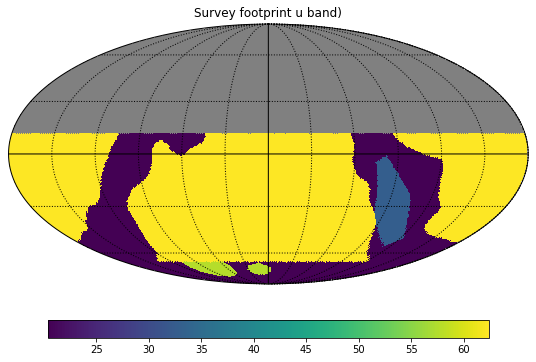

<Figure size 720x576 with 0 Axes>

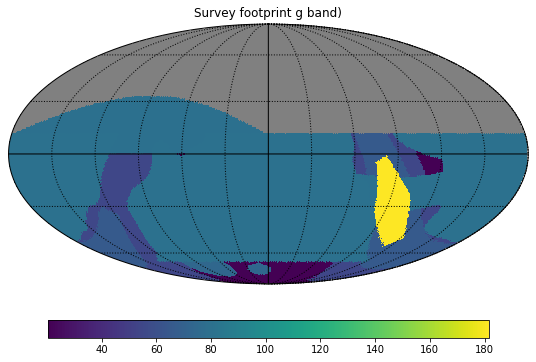

<Figure size 720x576 with 0 Axes>

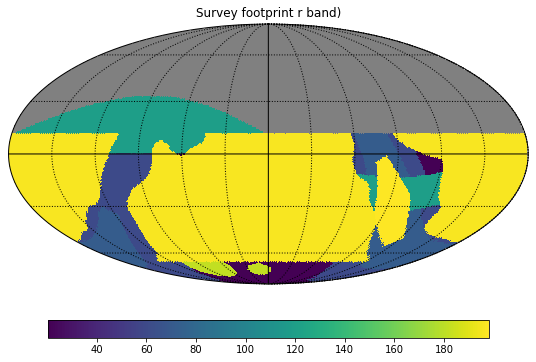

<Figure size 720x576 with 0 Axes>

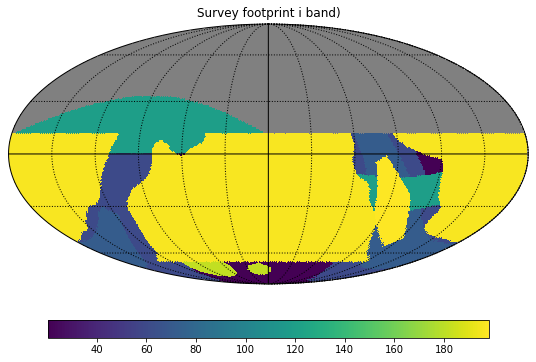

<Figure size 720x576 with 0 Axes>

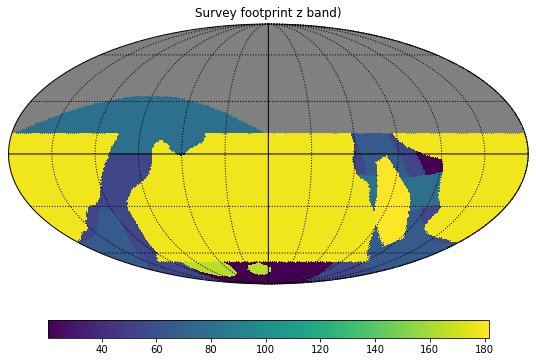

<Figure size 720x576 with 0 Axes>

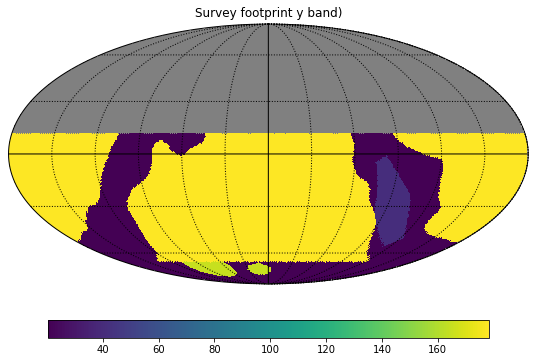

In [419]:
for f in sky.filterlist:
    fig = plt.figure(figsize=(10, 8))
    hp.mollview(np.where(survey_maps[f] < 1, hp.UNSEEN, survey_maps[f]), 
                cmap="viridis", cbar=False)
    # Add colorbar / extras
    hp.graticule(dpar=30, dmer=30, verbose=False)
    im = plt.gca().get_images()[0]
    cb = plt.colorbar(im, shrink=0.75, aspect=25, pad=0.1, orientation='horizontal',
                      extendrect=True)
    plt.title(f'Survey footprint {f} band)')

Some thoughts on this: it's pretty close to what we need . but there are lots of places I could have gotten this wrong or that these approximations don't map well against reality. Some places I could imagine a real simulation needing more time than approximated:

 * I've made an approximation of the effective area and then scaled by the median number of visits - both of these may be neglecting 'tails' in the distribution. Hopefully this is not a large effect, but this treatment could be wrong, and it could be fairly far wrong in the worst case.
 * there are plenty of 'edges' in the footprints -- the edge of the dust extinction limits for the extragalactic footprint and the many, many small areas in the galactic plane priority maps may be problematic. If a field of view doesn't map well onto these edges we will need more visits to cover the edge to the level that is desired. 
 * The footprint has been treated in an 'average' manner, without considering the effects of over or under subscription in various RA zones. This can push the number of visits that are possible in some parts of the sky below what is approximated here. 
 * The distribution of visits has been treated as though cadence doesn't matter; this is almost certainly not true for most of these points in the sky, but is hopefully close enough that it is not a large effect (as long as the cadence for the extragalactic pointings is consistent with what is needed in the wings of the galactic plane, this seems likely to be 'close enough'). 
 
However, most of the questions above seem reasonable to try to address with a simulation and see how bad the assumptions are. We'll give it a go, if it seems useful.

196.02000000000004


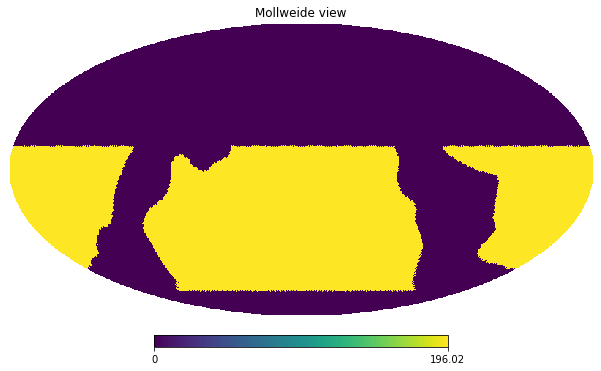

In [420]:
norm = np.median(survey_maps['r'][np.where(survey_maps['r']>0)[0]])
print(norm)
hp.mollview(np.where((survey_maps['r'] > norm-1) & (survey_maps['r'] < norm+1), survey_maps['r'], 0))

In [421]:
np.savez('survey_footprint', 
         u=survey_maps['u']/norm,
         g=survey_maps['g']/norm,
         r=survey_maps['r']/norm,
         i=survey_maps['i']/norm,
         z=survey_maps['z']/norm,
         y=survey_maps['y']/norm)

In [422]:
test = np.load('survey_footprint.npz')
test['r'].max()

1.01010101010101

196.02000000000004


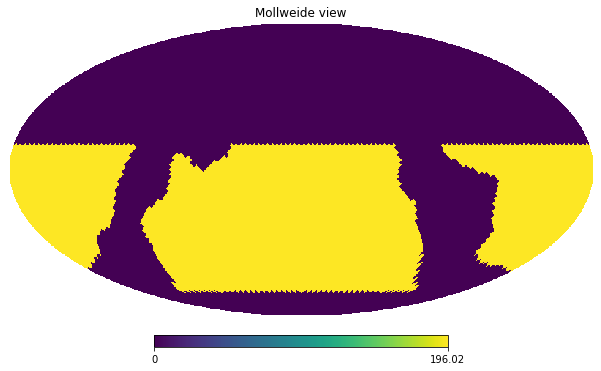

In [425]:
# downgrade the resolution to nside=32
import rubin_sim.utils as rsUtils

low_footprint = {}
new_nside = 32
new_surveyfootprint = rsUtils.healbin(sky.ra, sky.dec, surveyfootprint, nside=new_nside, reduceFunc=np.max, dtype=float)

new_survey_maps = {}
t = 0
for f in sky.filterlist:
    new_survey_maps[f] = rsUtils.healbin(sky.ra, sky.dec, survey_maps[f], nside=new_nside, reduceFunc=np.max, dtype=float)
    
new_norm = np.median(new_survey_maps['r'][np.where(new_survey_maps['r']>0)[0]])
print(new_norm)
hp.mollview(np.where((new_survey_maps['r'] > norm-1) & (new_survey_maps['r'] < norm+1), new_survey_maps['r'], 0))

In [40]:
np.savez('survey_footprint_32', 
         u=new_survey_maps['u']/new_norm,
         g=new_survey_maps['g']/new_norm,
         r=new_survey_maps['r']/new_norm,
         i=new_survey_maps['i']/new_norm,
         z=new_survey_maps['z']/new_norm,
         y=new_survey_maps['y']/new_norm)

<Figure size 720x576 with 0 Axes>

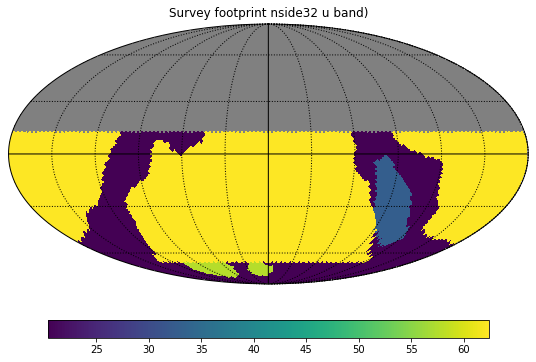

<Figure size 720x576 with 0 Axes>

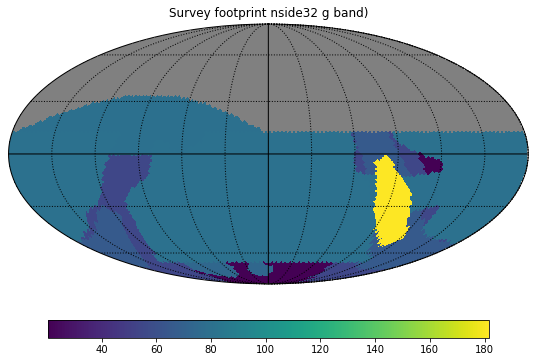

<Figure size 720x576 with 0 Axes>

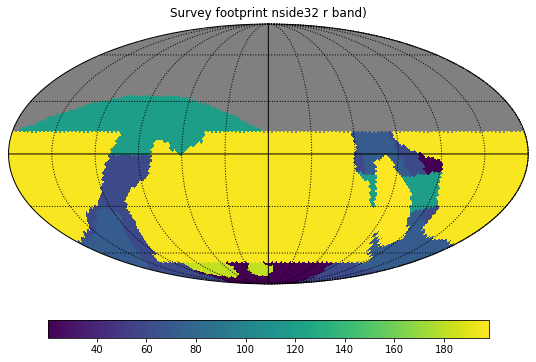

<Figure size 720x576 with 0 Axes>

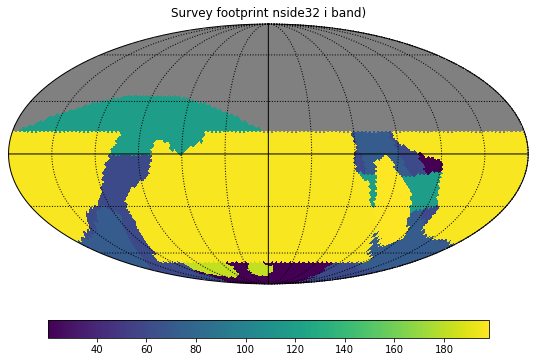

<Figure size 720x576 with 0 Axes>

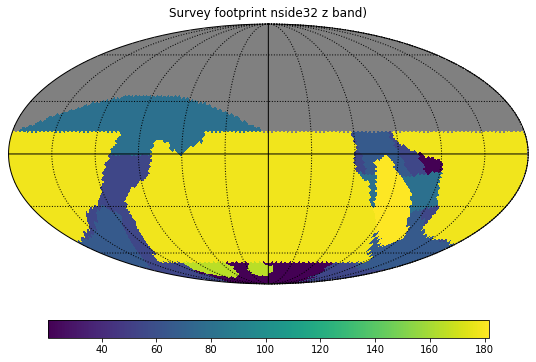

<Figure size 720x576 with 0 Axes>

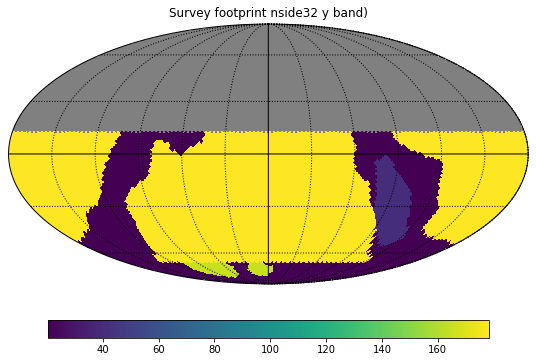

In [427]:
for f in sky.filterlist:
    fig = plt.figure(figsize=(10, 8))
    hp.mollview(np.where(new_survey_maps[f] < 1, hp.UNSEEN, new_survey_maps[f]), 
                cmap="viridis", cbar=False)
    # Add colorbar / extras
    hp.graticule(dpar=30, dmer=30, verbose=False)
    im = plt.gca().get_images()[0]
    cb = plt.colorbar(im, shrink=0.75, aspect=25, pad=0.1, orientation='horizontal',
                      extendrect=True)
    plt.title(f'Survey footprint nside32 {f} band)')